# **Project 1 − Cosmological Models**
## Advanced Simulation and Machine Learning | TIF345
## Chalmers University of Technology | Fall 2025
---
### Linus Brink | [brinkl@chalmers.se](mailto:brinkl@chalmers.se) 
### Oscar Stommendal | [oscarsto@chalmers.se](mailto:oscarsto@chalmers.se)
---

In [99]:
### Imports and plotting settings ###

import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy import integrate, optimize, stats


plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 14
plt.rcParams['font.size'] = font_size
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'




## **Task 1: Infer $H_0$ and $q_0$ based on the data set**

In [80]:
### Read data and define simulation parameters ###

data = np.loadtxt("data/SCPUnion2.1_mu_vs_z.txt", comments="#", usecols=(1,2,3,4))
z = data[:, 0] # redshift
z_05 = z[z < 0.5]
mu_obs = data[:, 1] # observed distance modulus
mu_obs_05 = mu_obs[z < 0.5]
mu_err = data[:, 2] # error in distance modulus
mu_err_05 = mu_err[z < 0.5]
data_sys = data[:, 3] # systematic error in distance modulus

c = 299792.458 # speed of light in km/s
H0_min, H0_max = 30, 100 # Hubble constant prior range in km/s/Mpc
q0_min, q0_max = -10, 10 # Deceleration parameter prior range
inv_gamma_a = 1.0 # inverse gamma parameter for systematic error model
inv_gamma_scale = 1.0 # inverse gamma scale for systematic error model

# Combine stat + provided systematic errors into a measurement variance
s_meas = np.sqrt(mu_err_fit**2 + data_sys_fit**2)  # shape of the errors

c = 299792.458  # speed of light in km/s
H0_min, H0_max = 30, 100
q0_min, q0_max = -2, 2

# Inverse-gamma prior hyperparameters for the *scale* sigma^2
inv_gamma_a     = 1.0
inv_gamma_scale = 1.0  # so sigma^2 ~ O(1) a priori

# Very-low-z H0 sanity check (optional)
mini_mask = z < 0.05
d_L = (10**((mu_obs[mini_mask] + 5) / 5)) / 1e6  # in Mpc
H_0 = c * z[mini_mask] / d_L
print(f"Estimated H0 from very low-z data: {np.median(H_0):.2f} ± {np.std(H_0):.2f} km/s/Mpc")





Estimated H0 from very low-z data: 68.31 ± 5.75 km/s/Mpc


In [81]:
def mu_theory(z, H0, q0, c):
    """Distance modulus using the small-z approximation."""
    dL_MPc = c / H0 * (z + 0.5 * (1 - q0) * z**2)
    mu = 5 * np.log10(dL_MPc) + 25
    return mu

def log_prior(theta):
    """Calculate the log prior probability for the parameters."""
    H0, q0, sigma_sys_log = theta
    sigma_sys = np.exp(sigma_sys_log)
    if H0_min < H0 < H0_max and q0_min < q0 < q0_max and sigma_sys > 0:
        logp_sigma_sys = stats.invgamma.logpdf(sigma_sys, a=inv_gamma_a, scale=inv_gamma_scale)
        return logp_sigma_sys
    return -np.inf

def log_likelihood(theta, z, mu_obs, mu_err):
    """Calculate the log likelihood of the observed data given the model parameters."""
    H0, q0, sigma_sys_log = theta
    sigma_sys = np.exp(sigma_sys_log)
    mu_model = mu_theory(z, H0, q0, c)
    s2 = s_meas**2
    var = sigma2 * s2  # weights ∝ 1 / s2, as required
    if np.any(var <= 0) or np.any(np.isnan(mu_model)):
        return -np.inf
    return -0.5 * np.sum((mu_obs - mu_model)**2 / var + np.log(2 * np.pi * var))

def log_posterior(theta, z, mu_obs, s_meas):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, z, mu_obs, s_meas)





In [84]:
### Run MCMC ###

ndim = 3
nwalkers = 100

p0 = np.zeros((nwalkers, ndim))
p0[:,0] = 70.0 + 10 * np.random.randn(nwalkers)
p0[:,1] = 0.0 + 2 * np.random.randn(nwalkers)
p0[:,2] = np.log(np.abs(1e-1 * np.random.randn(nwalkers)))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z_05, mu_obs_05, mu_err_05))
print("Running burn-in...")
pos, prob, state = sampler.run_mcmc(p0, 1000, progress=True)
sampler.reset()

print("Running production...")
sampler.run_mcmc(pos, 5000, progress=True)

samples = sampler.get_chain(flat=True)
H0_samples   = samples[:, 0]
q0_samples   = samples[:, 1]
sigma2_post  = samples[:, 2]   # posterior on sigma^2





You must install the tqdm library to use progress indicators with emcee


Running burn-in...


  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/3z/njryns916658jt56y6zm3xfw0000gn/T/ipykernel_54665/3102326521.py:6: RuntimeWarning: invalid value encountered in log10
  mu = 5 * np.log10(dL_MPc) + 25
100%|██████████| 1000/1000 [00:27<00:00, 36.17it/s]


Running production...


100%|██████████| 5000/5000 [02:10<00:00, 38.36it/s]


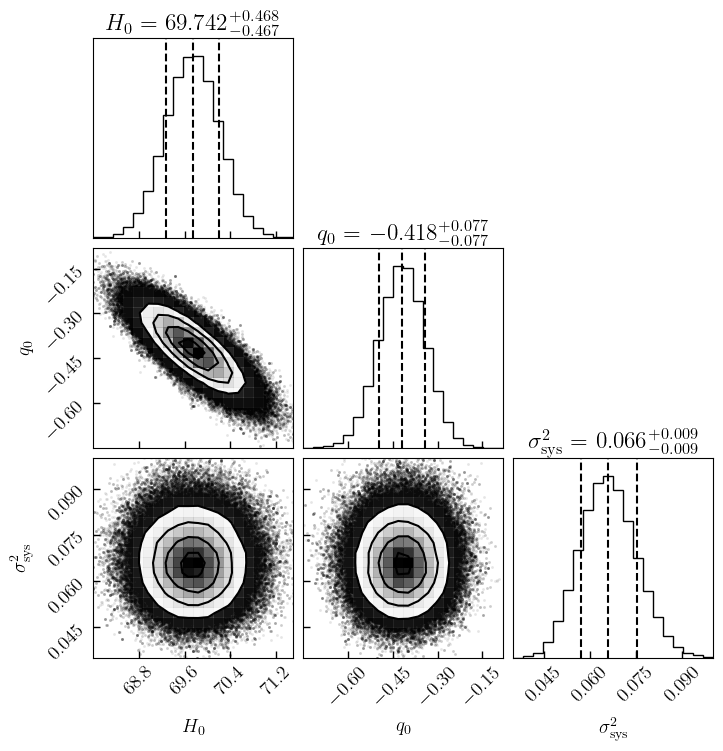

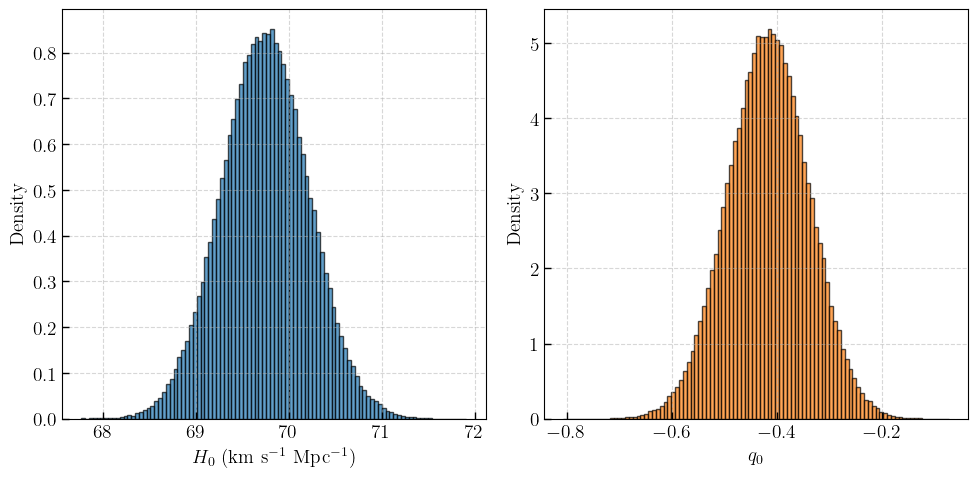

In [94]:
### Results ###

# Corner plot
fig = corner.corner(np.vstack([H0_samples, q0_samples, s2_samples]).T,
                    labels=[r"$H_0$", r"$q_0$", r"$\sigma_{\mathrm{sys}}^2$"],
                    range=[[68, 71.5], [-0.75, -0.08], [0.035, 0.1]],
                    show_titles=True,
                    title_fmt=".3f",
                    quantiles=[0.16, 0.5, 0.84])
# fig.savefig("posterior_corner.png")

# Histograms of individual parameters
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].hist(H0_samples, bins=100, density=True, color='tab:blue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel(r"$H_0$ (km s$^{-1}$ Mpc$^{-1}$)")
axes[0].set_ylabel("Density")
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[1].hist(q0_samples, bins=100, density=True, color='tab:orange', alpha=0.7, edgecolor='black')
axes[1].set_xlabel(r"$q_0$")
axes[1].set_ylabel("Density")
axes[1].grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig("posterior_histograms.png")
plt.show()


In [7]:
### Posterior predictive plot of distance modulus ###

z_plot = np.linspace(0.01, 1.5, 100)
mu_model_samples = np.array([mu_theory(z_plot, H0, q0, c) for H0, q0 in zip(H0_samples, q0_samples)])
mu_model_median = np.median(mu_model_samples, axis=0)



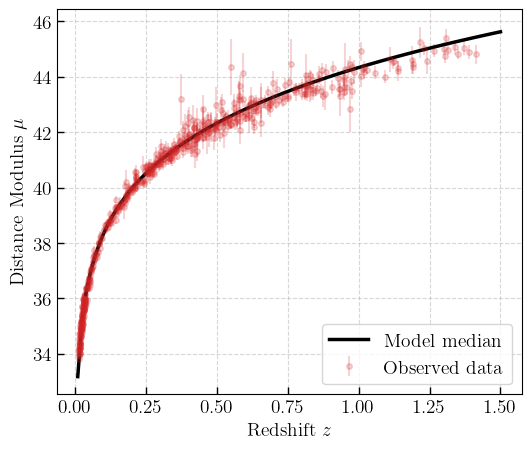

In [8]:

plt.figure(figsize=(6,5))

plt.errorbar(z, mu_obs, yerr=mu_err, fmt='o', label='Observed data', alpha=0.2, color='tab:red', markersize=4)
plt.plot(z_plot, mu_model_median, color='k', label='Model median', linewidth=2.5)
plt.xlabel("Redshift $z$")
plt.ylabel("Distance Modulus $\\mu$")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

## **Task 2: Cosmological Models Comparison**

In [101]:

# Bounds for optimizer
H0_bounds = (30.0, 100.0)
Om_bounds = (0.0, 1.0)
w_bounds = (-3.0, 1.0)

# Model utilities
def E_sqrt_z(zp, Om, w):
    Ol = 1.0 - Om
    return np.sqrt(Om * (1 + zp)**3 + Ol * (1 + zp)**(3 * (1 + w)))

def dL_Mpc(H0, Om, w, z):
    # dL = c (1+z) * integral_0^z dz' / H(z')  ; H(z) = H0 * E_sqrt_z
    # so dL = (c/H0) (1+z) * integral_0^z dz' / E(z')
    def integrand(zp):
        return 1.0 / E_sqrt_z(zp, Om, w)
    I = np.array([integrate.quad(integrand, 0.0, zi, epsabs=1e-8, epsrel=1e-8)[0] for zi in np.atleast_1d(z)])
    return (c / H0) * (1.0 + np.atleast_1d(z)) * I

def mu_model(theta, z, model="wCDM"):
    # theta: for wCDM [H0, Om, w], for LCDM [H0, Om]
    if model == "LCDM":
        H0, Om = theta
        w = -1.0
    else:
        H0, Om, w = theta
    dL = dL_Mpc(H0, Om, w, z)
    mu = 5.0 * np.log10(dL) + 25.0
    return mu

# Likelihood/objective
def neg_loglike_theta(theta, z, mu_obs, sigma, model):
    mu_pred = mu_model(theta, z, model=model)
    resid = mu_obs - mu_pred
    # Gaussian with known sigma_i
    chi2 = np.sum((resid / sigma)**2)
    # include normalization constant for likelihood (useful for AIC/BIC via logL)
    logL = -0.5 * (chi2 + np.sum(np.log(2 * np.pi * sigma**2)))
    return -logL  # we minimize negative log-likelihood

# AIC/BIC helpers
def compute_ic(logL_max, k, n):
    aic = - 2 * k + 2 * logL_max
    bic = - k * np.log(n) + 2 * logL_max
    return aic, bic

N = len(z)

# Fit LCDM (k=2 parameters: H0, Om)
k_lcdm = 2
x0 = np.array([70.0, 0.3])
bounds_lcdm = [H0_bounds, Om_bounds]

res_lcdm = optimize.minimize(
    neg_loglike_theta, x0, args=(z, mu_obs, mu_err, "LCDM"),
    bounds=bounds_lcdm, method="nelder-mead"
)

theta_lcdm = res_lcdm.x
neglogL_lcdm = res_lcdm.fun
logL_lcdm = -neglogL_lcdm
aic_lcdm, bic_lcdm = compute_ic(logL_lcdm, k_lcdm, N)

# Fit wCDM (k=3 parameters: H0, Om, w)
k_wcdm = 3
x0 = np.array([70.0, 0.3, -1.0])
bounds_wcdm = [H0_bounds, Om_bounds, w_bounds]

res_wcdm = optimize.minimize(
    neg_loglike_theta, x0, args=(z, mu_obs, mu_err, "wCDM"),
    bounds=bounds_wcdm, method="nelder-mead"
)

theta_wcdm = res_wcdm.x
neglogL_wcdm = res_wcdm.fun
logL_wcdm = -neglogL_wcdm
aic_wcdm, bic_wcdm = compute_ic(logL_wcdm, k_wcdm, N)

# --- report ---
def print_result(name, theta, aic, bic):
    print(f"\n{name} best-fit:")
    if name == "LCDM":
        print(f"  H0 = {theta[0]:.3f}  Om = {theta[1]:.3f}")
    else:
        print(f"  H0 = {theta[0]:.3f}  Om = {theta[1]:.3f}  w = {theta[2]:.3f}")
    print(f"  AIC = {aic:.3f}")
    print(f"  BIC = {bic:.3f}")

print_result("LCDM", theta_lcdm, aic_lcdm, bic_lcdm)
print_result("wCDM", theta_wcdm, aic_wcdm, bic_wcdm)

# --- model selection guidance ---
delta_aic = aic_wcdm - aic_lcdm
delta_bic = bic_wcdm - bic_lcdm
print("\nModel comparison (wCDM - LCDM):")
print(f"  ΔAIC = {delta_aic:.3f}  (positive -> LCDM preferred)")
print(f"  ΔBIC = {delta_bic:.3f}  (positive -> LCDM preferred)")



LCDM best-fit:
  H0 = 70.002  Om = 0.278
  AIC = 233.481
  BIC = 224.755

wCDM best-fit:
  H0 = 70.018  Om = 0.281  w = -1.010
  AIC = 231.483
  BIC = 218.394

Model comparison (wCDM - LCDM):
  ΔAIC = -1.998  (positive -> LCDM preferred)
  ΔBIC = -6.361  (positive -> LCDM preferred)


In [108]:

def E(zp, Om):
    Ol = 1.0 - Om
    return np.sqrt(Om * (1 + zp)**3 + Ol)

def dL_Mpc(H0, Om, zvals):
    # vectorized numeric integral for each z
    def integrand(zp, Om):
        return 1.0 / E(zp, Om)
    I = np.array([integrate.quad(lambda zp: integrand(zp, Om), 0.0, zi, epsabs=1e-8, epsrel=1e-8)[0]
                  for zi in np.atleast_1d(zvals)])
    return (c_km_s / H0) * (1.0 + np.atleast_1d(zvals)) * I

def mu_pred_vec(H0, Om, zvals):
    dL = dL_Mpc(H0, Om, zvals)
    return 5.0 * np.log10(dL) + 25.0

# --- log-likelihood for given (H0, Om) ---
def log_likelihood(H0, Om):
    mu_pred = mu_pred_vec(H0, Om, z)
    resid = mu_obs - mu_pred
    chi2 = np.sum((resid / mu_err)**2)
    lognorm = -0.5 * np.sum(np.log(2.0 * np.pi * mu_err**2))
    return -0.5 * chi2 + lognorm

Om_grid = np.linspace(0.0, 1.0, 51)   # grid for Omega_M in [0,1]
H0_grid = np.linspace(20.0, 120.0, 51)  # prior for H0 (uniform); adjust if desired

# --- compute marginal posterior p(Om) ∝ ∫ L(H0,Om) p(H0) dH0 with uniform p(H0) ---
dH0 = H0_grid[1] - H0_grid[0]
logp_om = np.empty_like(Om_grid)
for i, Om in enumerate(Om_grid):
    logL_H0 = np.array([log_likelihood(H0, Om) for H0 in H0_grid])
    # stable integration using log-sum-exp with trapezoid weights
    max_logL = logL_H0.max()
    weights = np.ones_like(H0_grid)
    weights[0] = weights[-1] = 0.5
    sum_exp = np.sum(np.exp(logL_H0 - max_logL) * weights)
    log_integral = max_logL + np.log(sum_exp) + np.log(dH0)
    logp_om[i] = log_integral  # prior on Om is uniform in [0,1] -> constant

# normalize posterior
logp_om -= np.max(logp_om)  # prevent overflow
p_om = np.exp(logp_om)
p_om /= np.trapz(p_om, Om_grid)

# credible summaries
cdf = np.cumsum(p_om) * (Om_grid[1] - Om_grid[0])
median = np.interp(0.5, cdf, Om_grid)
lo16 = np.interp(0.16, cdf, Om_grid)
hi84 = np.interp(0.84, cdf, Om_grid)

/var/folders/3z/njryns916658jt56y6zm3xfw0000gn/T/ipykernel_54665/1150070456.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_om /= np.trapz(p_om, Om_grid)


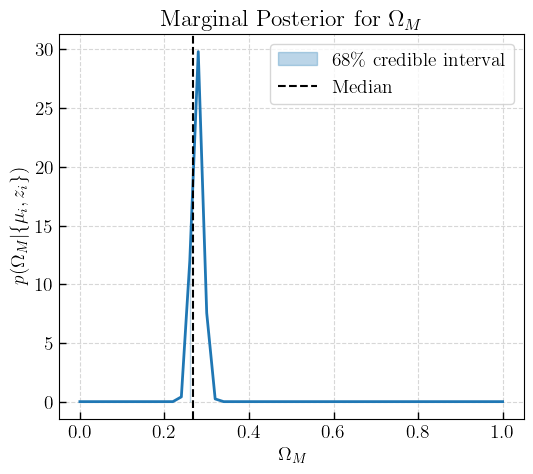

In [109]:
### Plot marginal posterior for Omega_M ###
plt.figure(figsize=(6,5))
plt.plot(Om_grid, p_om, color='tab:blue', linewidth=2)
plt.fill_between(Om_grid, 0, p_om, where=(Om_grid >= lo16) & (Om_grid <= hi84), color='tab:blue', alpha=0.3,label='68\\% credible interval')
plt.axvline(median, color='k', linestyle='--', label='Median')
plt.xlabel(r'$\Omega_M$')
plt.ylabel(r'$p(\Omega_M | \{ \mu_i, z_i \})$')
plt.title('Marginal Posterior for $\\Omega_M$')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()